In [1]:
#Data downloaded from https://janelia.figshare.com/articles/dataset/Recordings_of_ten_thousand_neurons_in_visual_cortex_in_response_to_2_800_natural_images/6845348

In [24]:
from EnsemblePursuit.EnsemblePursuit import EnsemblePursuit
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.linear_model import ridge_regression
import torch
from scipy.ndimage import gaussian_filter
import cv2

In [117]:
dat_path='C:/Users/koester_lab/Documents/Maria/CarsenData/2800/natimg2800_M170717_MP033_2017-08-20.mat'
dat_path='C:/Users/koester_lab/Documents/Maria/CarsenData/2800/natimg2800_M170717_MP034_2017-09-11.mat'
im_path='C:/Users/koester_lab/Downloads/images_natimg2800_all.mat'

In [140]:
from scipy.stats import zscore
from scipy.sparse.linalg import eigsh


def subtract_spont(spont,resp):
    #print(spont)
    mu = spont.mean(axis=0)
    sd = spont.std(axis=0) + 1e-6
    resp = (resp - mu) / sd
    spont = (spont - mu) / sd
    sv,u = eigsh(spont.T @ spont, k=32)
    resp = resp - (resp @ u) @ u.T
    return resp

def test_train_split(data,stim):
    unique, counts = np.unique(stim.flatten(), return_counts=True)
    count_dict=dict(zip(unique, counts))

    keys_with_enough_data=[]
    for key in count_dict.keys():
        if count_dict[key]==2:
            keys_with_enough_data.append(key)

    filtered_stims=np.isin(stim.flatten(),keys_with_enough_data)

    #Arrange data so that responses with the same stimulus are adjacent
    z=stim.flatten()[np.where(filtered_stims)[0]]
    sortd=np.argsort(z)
    istim=np.sort(z)
    X=data[filtered_stims,:]
    out=X[sortd,:].copy()

    x_train=out[::2,:]
    y_train=istim[::2]
    x_test=out[1::2,:]
    y_test=istim[1::2]

    return x_train, x_test, y_train, y_test

def zscore_utils(X, axis=0):
    mean_X= np.mean(X,axis=axis)
    std_X = np.std(X, axis=axis) + 1e-10
    X -= np.expand_dims(mean_X, axis)
    X /= np.expand_dims(std_X, axis)

    return X

def plot_all_receptive_fields(B):
    fig=plt.figure(figsize=(15, 10))
    for ind1 in range(50):
        #vmin=np.min(assembly_array[ind1,ind2,:])
        vmax=np.max(B) * 2/3
        plt.subplot(10, 5, ind1+1)
        plt.imshow(B[:,:,ind1],cmap='bwr',vmin=-vmax,vmax=vmax)
        plt.axis('off')
        plt.title(str(ind1))
    plt.show()

def fit_ridge_with_plot(im_path,dat_path):
    
    img=loadmat(im_path)['imgs']
    data=loadmat(dat_path)
    resp = data['stim'][0]['resp'][0]
    spont =data['stim'][0]['spont'][0]
    X=subtract_spont(spont,resp)
    X = zscore_utils(X, axis=1)
    model=EnsemblePursuit(n_components=50,lam=0.01,n_kmeans=50)
    model.fit(X)
    V = model.components_
    stim = data['stim']['istim'][0][0].astype(np.int32)
    print(stim.shape)
    ishape = (img.shape[0]//5, img.shape[1]//5)
    images = np.zeros((2800, ) + (ishape[0], ishape[1]))
    for j in range(images.shape[0]):
        images[j] = cv2.resize(img[:,:,j], (ishape[1], ishape[0]))
    images = images.reshape((2800, -1))
    images = zscore_utils(images, axis=1)
    #stim = data['stim']['istim'][0][0].astype(np.int32)
    x_train,x_test,y_train,y_test=test_train_split(V,stim)
    y_train=y_train-1
    images_ = images[y_train]
    print(images_.shape)
    av_resp = (x_train + x_test)/2
    B = np.linalg.solve(images_.T @ images_ +  100 * np.eye(images_.shape[1]), images_.T @ av_resp)
    print(B.shape)
    B = np.reshape(B, ishape+(50,))
    print(B.shape)
    B = gaussian_filter(B, (.5, .5, 0))
    plot_all_receptive_fields(B)

obtained 50 PCs in 1.0423 seconds
initialized 50 clusters with k-means in 9.4485 seconds
ensemble 0, time 2.18, nr neurons 1452, EV 0.0042
ensemble 25, time 26.15, nr neurons 171, EV 0.0317
ensemble 49, time 40.71, nr neurons 90, EV 0.0450
average sparsity is 0.0270
(5880, 1)
(2800, 702)
(702, 50)
(13, 54, 50)


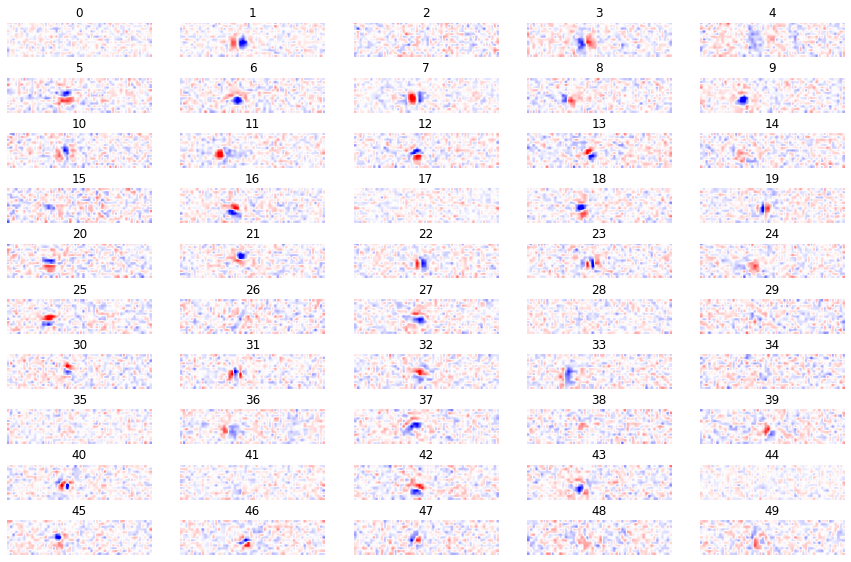

In [119]:
fit_ridge_with_plot(im_path,dat_path)

In [165]:
def plot_all_receptive_fields(B):
    fig=plt.figure(figsize=(15, 120))
    for ind1 in range(400):
        vmax=np.max(B) * 2/3
        plt.subplot(80, 5, ind1+1)
        plt.imshow(B[:,:,ind1],cmap='bwr',vmin=-vmax,vmax=vmax)
        plt.axis('off')
        plt.title(str(ind1))

def individual_rf(im_path,dat_path):
    img=loadmat(im_path)['imgs']
    data=loadmat(dat_path)
    resp = data['stim'][0]['resp'][0]
    spont =data['stim'][0]['spont'][0]
    X=subtract_spont(spont,resp)
    X = zscore_utils(X, axis=1)
    model=EnsemblePursuit(n_components=5,lam=0.01,n_kmeans=5)
    model.fit(X)
    stim = data['stim']['istim'][0][0].astype(np.int32)
    print(stim.shape)
    ishape = (img.shape[0]//5, img.shape[1]//5)
    images = np.zeros((2800, ) + (ishape[0], ishape[1]))
    for j in range(images.shape[0]):
        images[j] = cv2.resize(img[:,:,j], (ishape[1], ishape[0]))
    images = images.reshape((2800, -1))
    images = zscore_utils(images, axis=1)
    #stim = data['stim']['istim'][0][0].astype(np.int32)
    ens_n=1
    print(model.weights.shape)
    neurons=np.nonzero(model.weights[:,ens_n].flatten())
    neuron_dat=X[:,neurons].reshape(5880,-1)
    print('Neuron dat shp: ', neuron_dat.shape)
    x_train,x_test,y_train,y_test=test_train_split(neuron_dat,stim)
    y_train=y_train-1
    images_ = images[y_train]
    print(images_.shape)
    av_resp = (x_train + x_test)/2
    B = np.linalg.solve(images_.T @ images_ +  100 * np.eye(images_.shape[1]), images_.T @ av_resp)
    print(B.shape)
    B = np.reshape(B, ishape+(neuron_dat.shape[1],))
    print(B.shape)
    B = gaussian_filter(B, (.5, .5, 0))
    plot_all_receptive_fields(B)

obtained 5 PCs in 0.8654 seconds
initialized 5 clusters with k-means in 6.9132 seconds
ensemble 0, time 1.65, nr neurons 1452, EV 0.0042
ensemble 4, time 4.68, nr neurons 465, EV 0.0117
average sparsity is 0.0726
(5880, 1)
(10103, 5)
Neuron dat shp:  (5880, 642)
(2800, 702)
(702, 642)
(13, 54, 642)


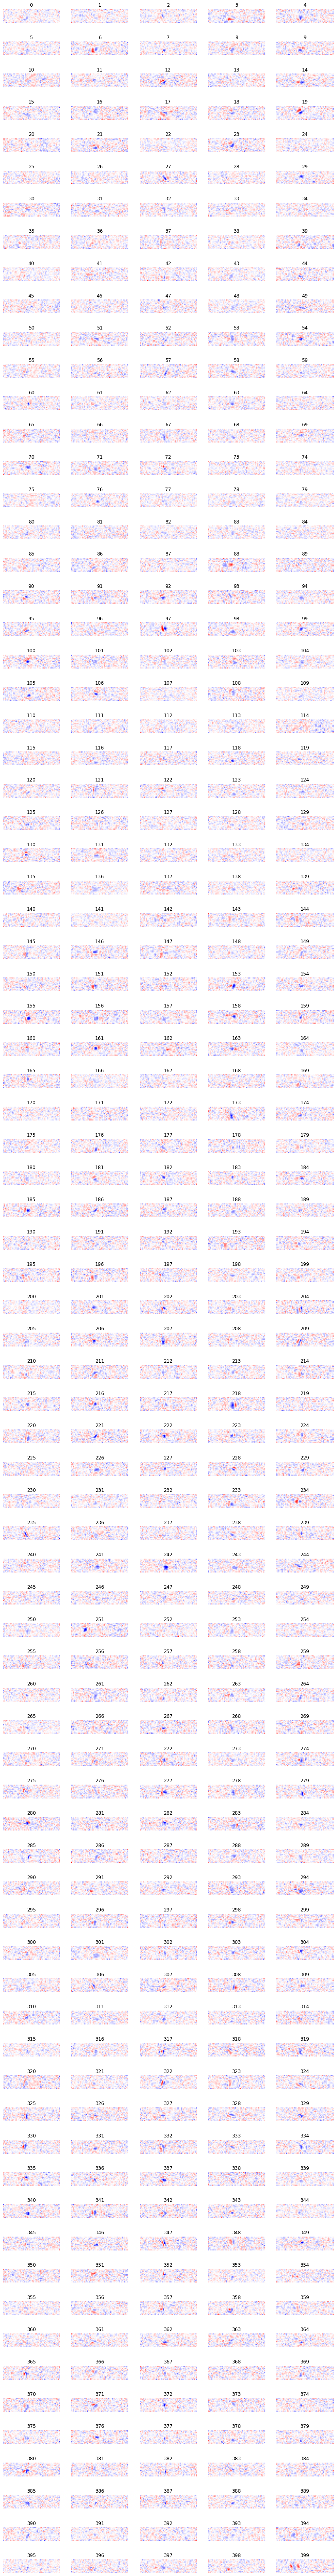

In [166]:
individual_rf(im_path,dat_path)

In [173]:
selected_ensembles=[1,3,5,6,7,8,9,10,11,12,13,16,18,19,20,21,22,27,30,32,36,37,39,42,47]
print(len(selected_ensembles))
print(np.unique(selected_ensembles).shape)

25
(25,)


obtained 50 PCs in 1.0320 seconds
initialized 50 clusters with k-means in 9.6269 seconds
ensemble 0, time 2.22, nr neurons 1452, EV 0.0042
ensemble 25, time 26.25, nr neurons 171, EV 0.0317
ensemble 49, time 40.88, nr neurons 90, EV 0.0450
average sparsity is 0.0270
(5880, 1)
(2800, 702)
(702, 50)
(13, 54, 50)


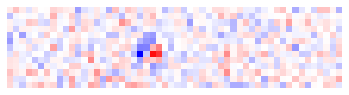

In [175]:
def save_ensemble_image(im_path,dat_path,selected_ensembles):
    img=loadmat(im_path)['imgs']
    data=loadmat(dat_path)
    resp = data['stim'][0]['resp'][0]
    spont =data['stim'][0]['spont'][0]
    X=subtract_spont(spont,resp)
    X = zscore_utils(X, axis=1)
    model=EnsemblePursuit(n_components=50,lam=0.01,n_kmeans=50)
    model.fit(X)
    V = model.components_
    stim = data['stim']['istim'][0][0].astype(np.int32)
    print(stim.shape)
    ishape = (img.shape[0]//5, img.shape[1]//5)
    images = np.zeros((2800, ) + (ishape[0], ishape[1]))
    for j in range(images.shape[0]):
        images[j] = cv2.resize(img[:,:,j], (ishape[1], ishape[0]))
    images = images.reshape((2800, -1))
    images = zscore_utils(images, axis=1)
    #stim = data['stim']['istim'][0][0].astype(np.int32)
    x_train,x_test,y_train,y_test=test_train_split(V,stim)
    y_train=y_train-1
    images_ = images[y_train]
    print(images_.shape)
    av_resp = (x_train + x_test)/2
    B = np.linalg.solve(images_.T @ images_ +  100 * np.eye(images_.shape[1]), images_.T @ av_resp)
    print(B.shape)
    B = np.reshape(B, ishape+(50,))
    print(B.shape)
    B = gaussian_filter(B, (.5, .5, 0))
    i=0
    for ind1 in selected_ensembles:
        #vmin=np.min(assembly_array[ind1,ind2,:])
        vmax=np.max(B) * 2/3
        plt.imshow(B[:,:,ind1],cmap='bwr',vmin=-vmax,vmax=vmax)
        plt.axis('off')
        plt.savefig('C:/Users/koester_lab/Documents/Maria/mariakesa.github.io/img/ensemble_rf/ensemble_rf_'+str(i)+'.png')
        i+=1
        
save_ensemble_image(im_path,dat_path,selected_ensembles)